# Post-stack inversion of Volve data

**Author: M. Ravasi, KAUST**

Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

The aim of this tutorial is to:

- Utilize PyLops to perform seismic post-stack inversion of the Volve dataset;
- Familiarize with novel optimization techniques that can enhance the quality of your inversion using L1 regularization; 
- Get introduced to *PyProximal*, PyLops little sister library to perform even more advanced optimization by means of so-called proximal algorithms. 

Post-stack seismic modelling is the process of constructing seismic post-stack data from an acoustic impedance profile as function of time (or depth). From a mathematical point of view, this can be easily achieved using the following forward model:

$$
d(t, \theta) =  \frac{1}{2} w(t) * \frac{dln(m(t))}{dt}
$$
where $m(t)$ is the acoustic impedance profile and $w(t)$ is the time domain seismic wavelet. 

In compact form:

$$
\mathbf{d}= \mathbf{W} \mathbf{D} \mathbf{m}
$$

The associated inverse problems we wish to solve can written as:

- Least-squares
$$
J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon_1||\nabla_{x,y}\mathbf{m}||_2
$$

- L1-regularized
$$
J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon_1||\nabla_{x,y}\mathbf{m}||_2 + \epsilon_2||\mathbf{D}\mathbf{m}||_1
$$

- TV-regularized
$$
J = arg min_{\mathbf{m}} ||\mathbf{d} - \mathbf{W} \mathbf{D} \mathbf{m}||_2 + \epsilon TV(\mathbf{m})
$$

where $\nabla_{x,y}$ is the Laplacian along the x,y plane.

## Data retrieval

In order to be able to run this notebook we need to first make sure we have access to the Volve dataset. 

We cannot provide the data directly given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or ``pip install azure-cli`` would do).

First of all let's investigate what is present in the `Seismic` directory

In [1]:
#!az storage blob list --account-name datavillagesa --container-name volve --prefix Seismic/ --sas-token "$YOURTOKEN" > ../data/seismicinversion/list_seismic.txt

In [2]:
!head -n 60 data/list_seismic.txt

[
  {
    "container": "volve",
    "content": "",
    "deleted": null,
    "encryptedMetadata": null,
    "encryptionKeySha256": null,
    "encryptionScope": null,
    "isAppendBlobSealed": null,
    "isCurrentVersion": null,
    "lastAccessedOn": null,
    "metadata": {},
    "name": "Seismic/2D/ST0299/Navigation/ST0299-CMP.p190",
    "objectReplicationDestinationPolicy": null,
    "objectReplicationSourceProperties": [],
    "properties": {
      "appendBlobCommittedBlockCount": null,
      "blobTier": "Hot",
      "blobTierChangeTime": null,
      "blobTierInferred": true,
      "blobType": "BlockBlob",
      "contentLength": 237136,
      "contentRange": null,
      "contentSettings": {
        "cacheControl": null,
        "contentDisposition": null,
        "contentEncoding": null,
        "contentLanguage": null,
        "contentMd5": "YycxlvGGZqp4s7nW0TH3vQ==",
        "contentType": "text/plain; charset=utf-8"
      },
      "copy": {
        "completionTime": null,
        "

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

We can now download the file of interest

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy ../data/seismicinversion

In [4]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name datavillagesa --container-name volve --name Seismic/ST10010/Velocities/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --file ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy ../data/seismicinversion

Once the data is downloaded on your machine you are ready for the fun part of this notebook. More specifically, we will perform the following step:

- Data and velocity model are read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry);
- Velocity model is resampled to the data grid (both time and spatial sampling) and scaled to become the background AI for inversion;
- Absolute inversion is applied by means of ``pylops.avo.poststack.PoststackInversion``;
- TV regularized inversion is performed using ``PyProximal``.

## Data loading

Let's first import all the libraries we need

In [5]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal segyio scooby

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from pylops.basicoperators import *
from pylops.avo.poststack import *
from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion)

In [7]:
# Data
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # index of last time/depth sample in data used in colored inversion

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 2
jxl = 2

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT

# Trace-by-Trace Inversion
epsI_tt = 1e-3 # damping

# Spatially simultaneous
niter_sr = 3 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 1e2 # spatial regularization

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 1. # blocky regularization

Let's now read the Volve data.

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

(1961.0, 2679.0, 3200.0, 2404.0)

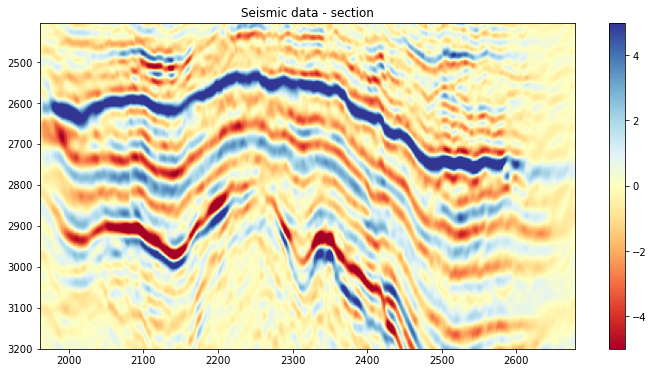

In [8]:
segyfile = 'data/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

We read also the migration velocity model. In this case, the SEG-Y file is in a regular grid, but the grid is different from that of the data. 

Let's resample the velocity model to the grid of the data.

In [9]:
segyfilev = 'data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

IL, XL, T = np.meshgrid(ilines, xlines, t, indexing='ij')

vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, 
                                  bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nt)

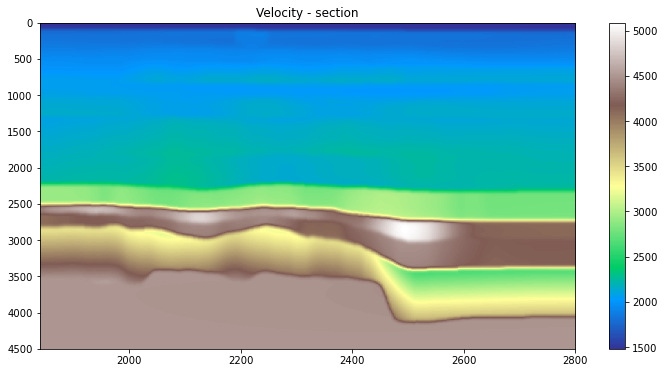

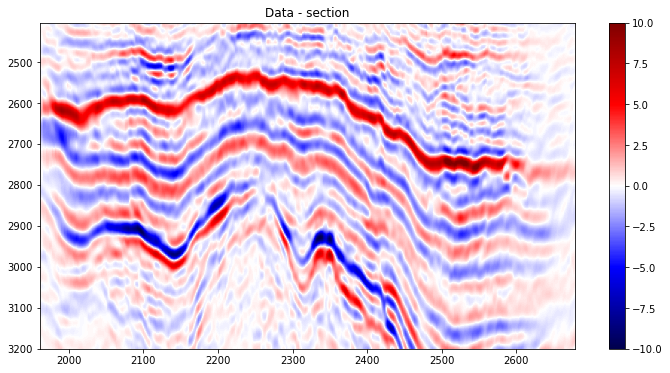

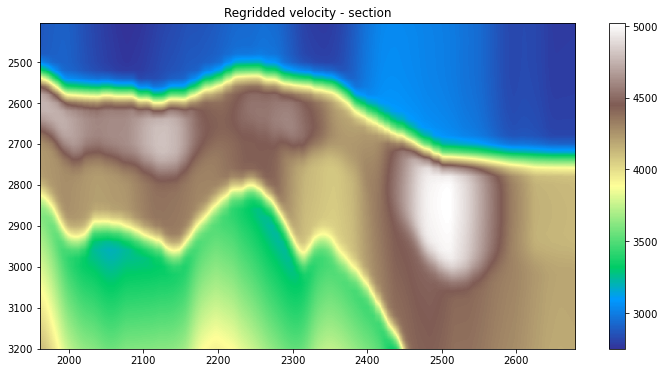

In [10]:
# Display data
plt.figure(figsize=(12, 6))
plt.imshow(v[len(fv.ilines)//2].T, cmap='terrain',
           extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.title('Velocity - section')
plt.colorbar()
plt.axis('tight')

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Data - section')
plt.colorbar()
plt.axis('tight');

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(vinterp[nil//2].T, cmap='terrain',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded velocity - section')
plt.colorbar()
plt.axis('tight');

## Velocity model preparation

We need now to scale this model to its acoustic impedance equivalent. 

This calibration step was performed outside of this notebook using a welllog and this velocity model along a well trajectory. In this example we will simply use a scaling (gradient) and a shift (intercept) from that study.

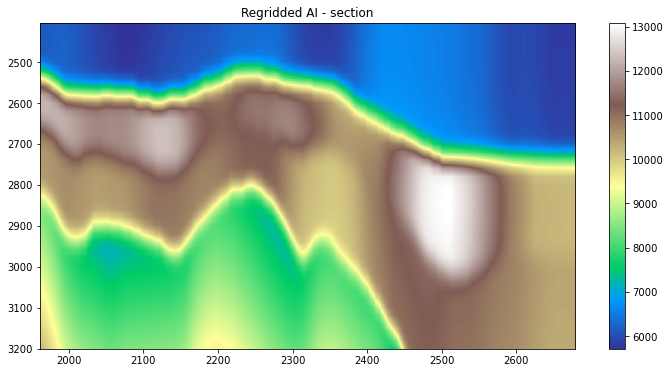

In [11]:
intercept = -3218.0003362662665
gradient = 3.2468122679241023

aiinterp = intercept + gradient*vinterp

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(aiinterp[nil//2].T, cmap='terrain',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded AI - section')
plt.colorbar()
plt.axis('tight');

## Statistical wavelet estimation

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

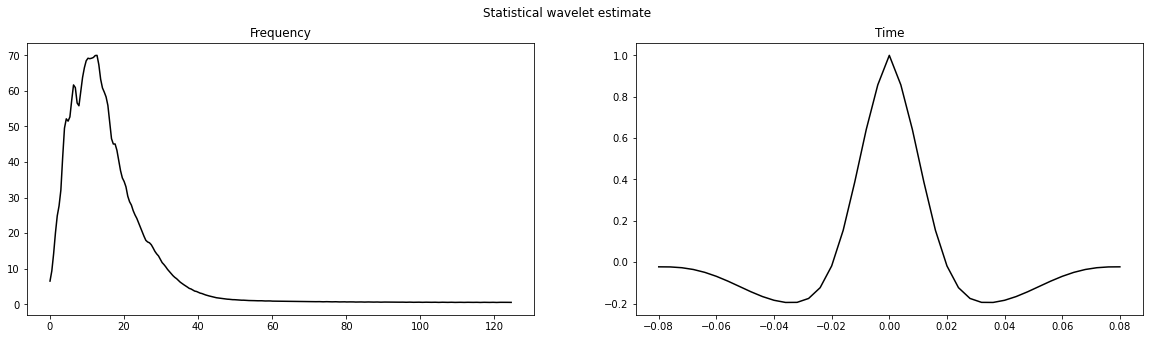

In [12]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## 2D Inversion

We can apply seismic inversion using a starting background AI model. The inverted AI model will therefore have the correct physical quantities of acoustic impedance.

In [13]:
# Swap time axis back to first dimension
d2d = d[nil//2].T
aiinterp2d = aiinterp[nil//2].T

m0 = np.log(aiinterp2d)
m0[np.isnan(m0)] = 0

### Inversion with least-squares solver

In [14]:
wav_amp = 1e1 # guessed as we have estimated the wavelet statistically
mls, rls = \
    pylops.avo.poststack.PoststackInversion(d2d, wav_amp*wav_est, m0=m0, explicit=False, 
                                            epsR=epsR_b,
                                            **dict(show=True, iter_lim=niter_b, damp=epsI_b))
mls = np.exp(mls).T

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 144000 rows and 72000 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.781e+02  4.781e+02    1.0e+00  3.2e-02
     1 -9.98364e-04   2.124e+02  2.124e+02    4.4e-01  5.4e-01   1.7e+01  1.0e+00
     2 -1.75151e-03   1.450e+02  1.450e+02    3.0e-01  3.5e-01   2.2e+01  2.2e+00
     3 -2.21677e-02   1.103e+02  1.103e+02    2.3e-01  2.6e-01   2.6e+01  3.6e+00
     4 -4.91789e-02   8.817e+01  8.817e+01    1.8e-01  2.1e-01   2.9e+01  5.3e+00
     5 -7.23960e-02   7.337e+01  7.337e+01    1.5e-01  1.7e-01   3.2e+01  7.0e+00
     6 -6.59324e-02   6.330e+01  6.330e+01    1.3e-01  1.5e-01   3.5e+01  8.9e+00
     7 -5.25435e-02   5.494e+01  5.494e+01    1.1e-01  1.3e-01   3.8e+01  1.1e+01
     8 -3.74643e-02   4.824e+01

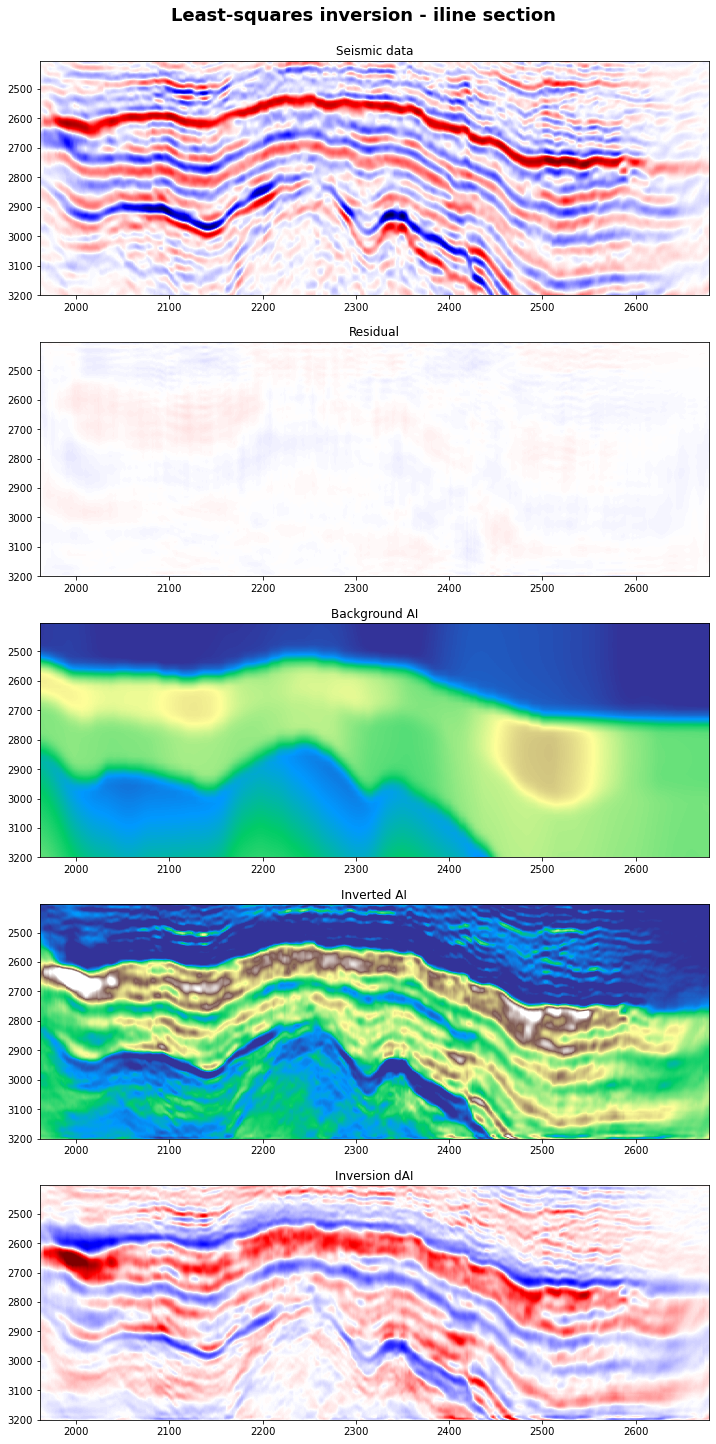

In [15]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Least-squares inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d2d, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rls, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp2d, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(mls.T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(mls.T - aiinterp2d, cmap='seismic',
              vmin=-0.7*(mls.T-aiinterp2d).max(), vmax=0.7*(mls.T-aiinterp2d).max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

### Inversion with Split-Bregman

In [16]:
msb, rsb = \
    pylops.avo.poststack.PoststackInversion(d2d, wav_amp*wav_est, m0=m0, explicit=False, 
                                            epsR=epsR_b, epsRL1=epsRL1_b,
                                            **dict(mu=mu_b, niter_outer=10, 
                                                   niter_inner=1, show=True,
                                                   iter_lim=40, damp=epsI_b))
msb = np.exp(msb).T

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 72000 rows and 72000 cols
niter_outer =  10     niter_inner =   1   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [1.0]	  epsL2 = [0.1]     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   9.09400e+00        1.668e+01        2.434e+03
     2   9.33999e+00        2.761e+01        2.328e+03
     3   9.28567e+00        4.375e+01        2.264e+03
     4   9.30212e+00        6.070e+01        2.224e+03
     5   9.30282e+00        7.773e+01        2.193e+03
     6   9.30234e+00        9.419e+01        2.168e+03
     7   9.30080e+00        1.095e+02        2.147e+03
     8   9.29695e+00        1.229e+02        2.134e+03
     9   9.29200e+00        1.345e+02        2.119e+03
    10   9.28627e+00        1.446e+02        2.100e+03

Iterations = 10        Total time (s) = 1.67
---------------------------------------------

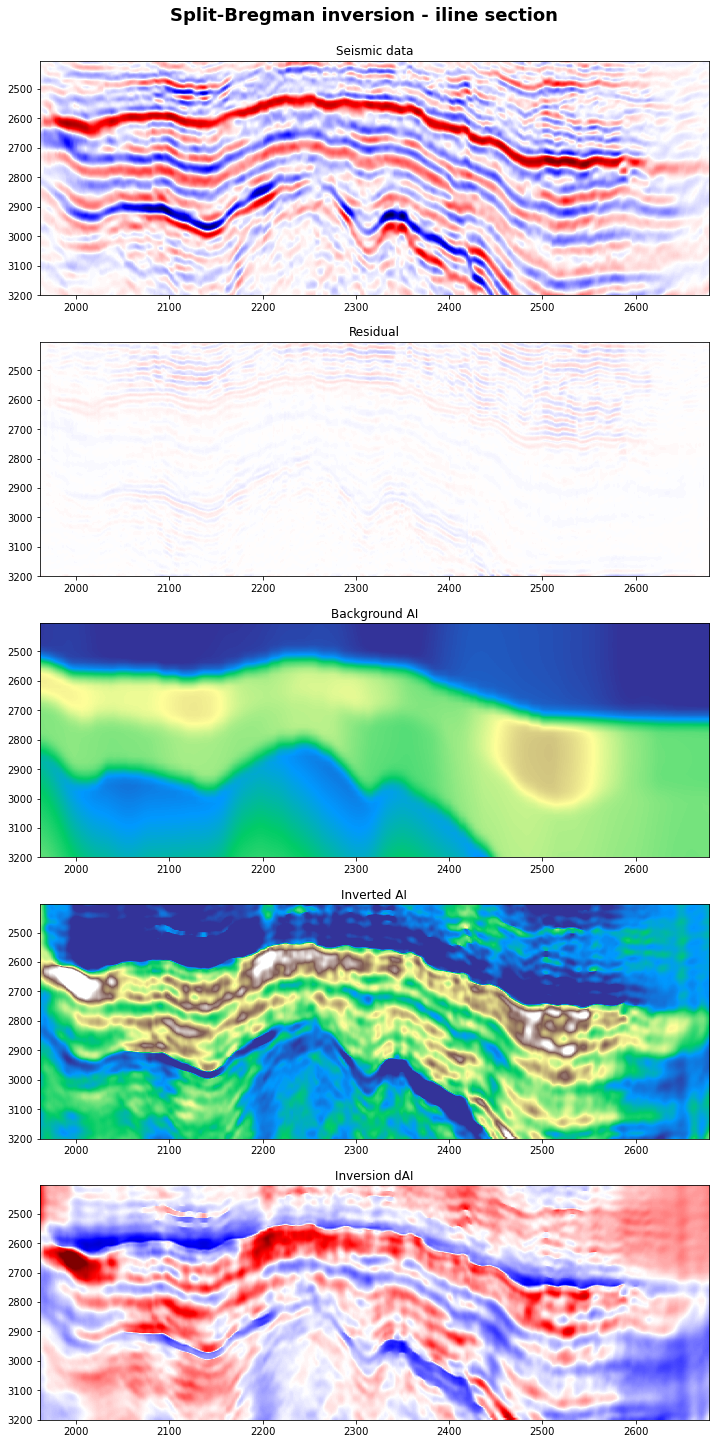

In [17]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Split-Bregman inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d2d, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rsb, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp2d, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(msb.T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(msb.T - aiinterp2d, cmap='seismic',
              vmin=-0.7*(mls.T-aiinterp2d).max(), vmax=0.7*(mls.T-aiinterp2d).max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

### Inversion with Primal-Dual

In [18]:
# Modelling operator
Lop = PoststackLinearModelling(wav_amp*wav_est, nt0=nt, spatdims=nxl)
l2 = L2(Op=Lop, b=d2d.ravel(), niter=70, warm=True)

# Regularization
sigma = 0.5
l1 = L21(ndim=2, sigma=sigma)
Dop = Gradient(dims=(nt, nxl), edge=True, dtype=Lop.dtype, kind='forward')

# Steps 
L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1. / np.sqrt(L)
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, m0.ravel(), tau=tau, mu=mu, theta=1., niter=50, show=True)
rpd = d2d.ravel() - Lop * mpd

mpd = np.exp(mpd).T
mpd = mpd.reshape(aiinterp2d.shape)
rpd = rpd.reshape(d2d.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.535534e-01	mu = 3.500179e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.49050e+00   1.102e+03   2.015e+03   0.000e+00       3.117e+03
     2   8.56054e+00   2.794e+02   1.880e+03   0.000e+00       2.160e+03
     3   8.61955e+00   1.782e+02   1.834e+03   0.000e+00       2.013e+03
     4   8.67312e+00   1.458e+02   1.806e+03   0.000e+00       1.952e+03
     5   8.72681e+00   1.340e+02   1.785e+03   0.000e+00       1.919e+03
     6   8.78197e+00   1.302e+02   1.765e+03   0.000e+00       1.895e+03
     7   8.83552e+00   1.298e+02   1.747e+03   0.000e+00       1.876e+03
     8   8.88222e+00   1.309e+02   1.

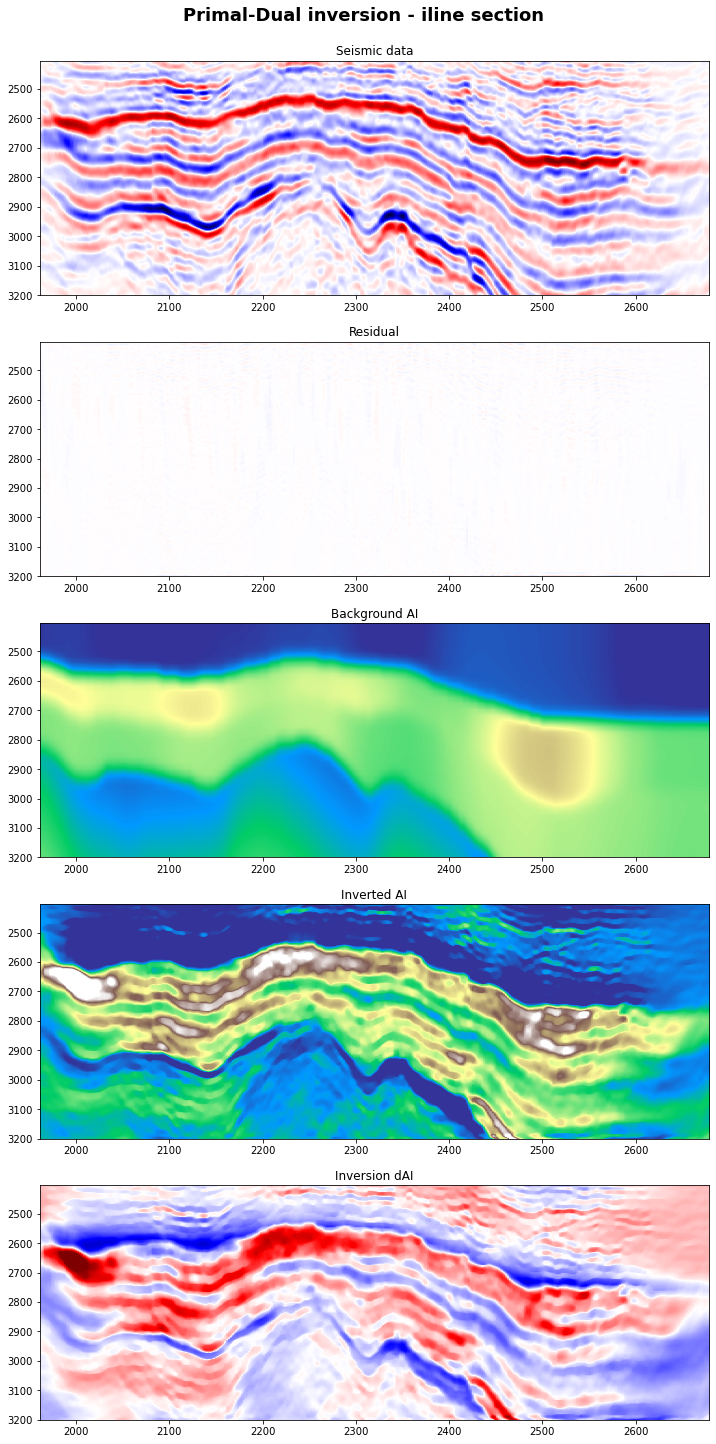

In [19]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Primal-Dual inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d2d, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rpd, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp2d, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(mpd, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(mpd - aiinterp2d, cmap='seismic',
              vmin=-0.7*(mls-aiinterp2d.T).max(), vmax=0.7*(mls-aiinterp2d.T).max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

Let's now visualize a single trace for the three inversions

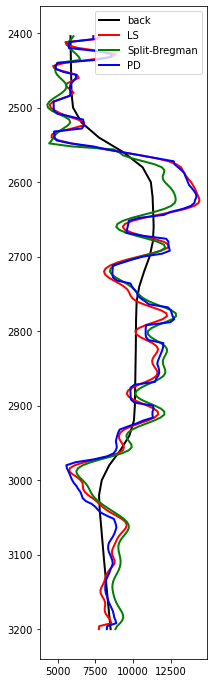

In [20]:
plt.figure(figsize=(3, 12))
plt.plot(aiinterp[nil//2,nxl//2], t, 'k', lw=2, label='back')
plt.plot(mls[nxl//2], t, 'r', lw=2, label='LS')
plt.plot(msb[nxl//2], t, 'g', lw=2, label='Split-Bregman')
plt.plot(mpd[:, nxl//2], t, 'b', lw=2, label='PD')
plt.gca().invert_yaxis()
plt.legend();

## 3D Inversion

### Inversion with least-squares solver

In [21]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Inversion
wav_amp = 1e1 # guessed as we have estimated the wavelet statistically
minv, rinv = \
    pylops.avo.poststack.PoststackInversion(d, wav_amp*wav_est, m0=m0, explicit=False, 
                                            epsR=epsR_b,
                                            **dict(show=True, iter_lim=niter_b, damp=epsI_b))
#minv, rinv = \
#    pylops.avo.poststack.PoststackInversion(d, wav_amp*wav_est, m0=m0, explicit=False, 
#                                            epsR=epsR_b, epsRL1=epsRL1_b,
#                                            **dict(mu=mu_b, niter_outer=niter_out_b, 
#                                                   niter_inner=niter_in_b, show=True,
#                                                   iter_lim=niter_b, damp=epsI_b))

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
minv = np.swapaxes(np.exp(minv), 0, -1)
rinv = np.swapaxes(rinv, 0, -1)

<ipython-input-21-780e0c8ab0cb>:5: RuntimeWarning: invalid value encountered in log
  m0 = np.log(aiinterp)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 28944000 rows and 14472000 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.941e+03  6.941e+03    1.0e+00  2.3e-03
     1  2.91663e-04   2.948e+03  2.948e+03    4.2e-01  5.5e-01   1.7e+01  1.0e+00
     2  8.48306e-04   2.004e+03  2.004e+03    2.9e-01  3.5e-01   2.2e+01  2.2e+00
     3  1.68877e-03   1.518e+03  1.518e+03    2.2e-01  2.5e-01   2.6e+01  3.6e+00
     4  2.73650e-03   1.240e+03  1.240e+03    1.8e-01  2.0e-01   2.9e+01  5.2e+00
     5  4.07560e-03   1.049e+03  1.049e+03    1.5e-01  1.7e-01   3.2e+01  7.0e+00
     6  5.66421e-03   9.081e+02  9.081e+02    1.3e-01  1.4e-01   3.5e+01  9.0e+00
     7  7.50241e-03   8.009e+02  8.009e+02    1.2e-01  1.2e-01   3.8e+01  1.1e+01
     8  9.50411e-03   7.20

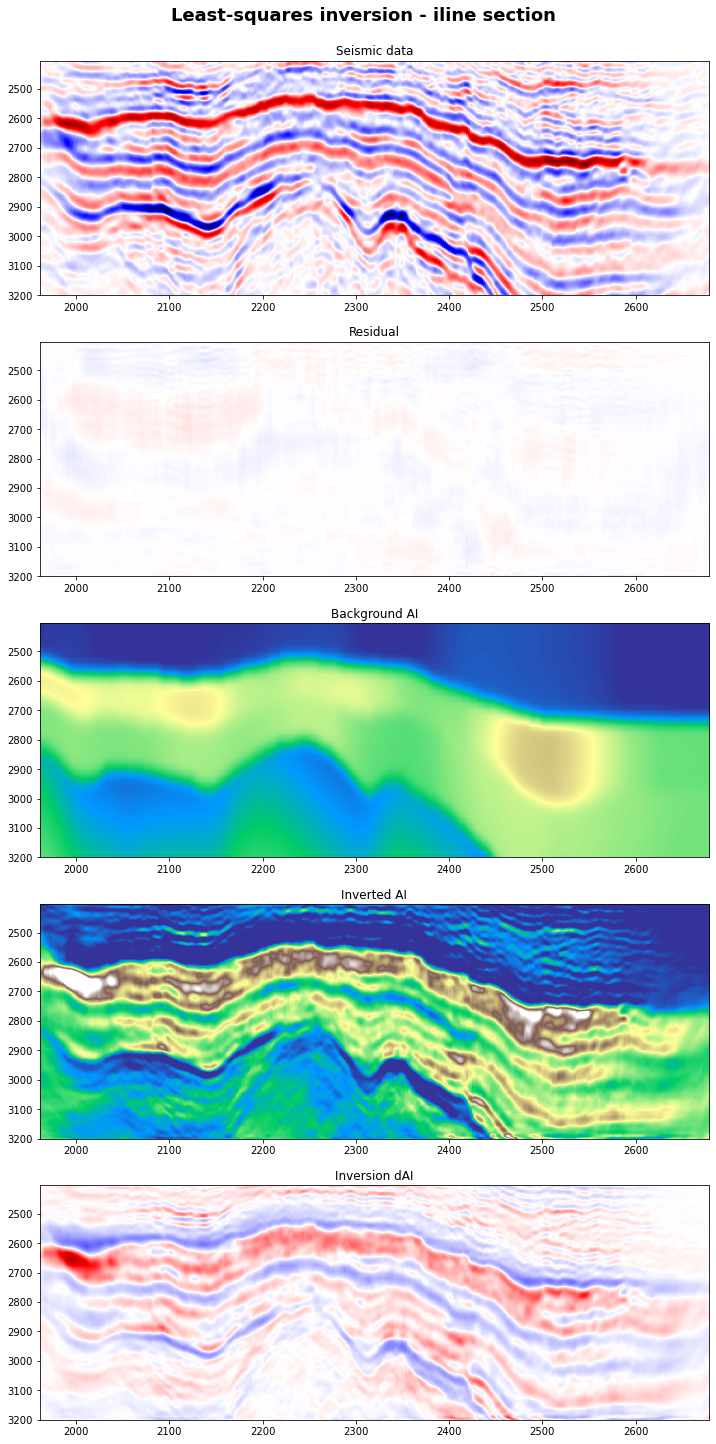

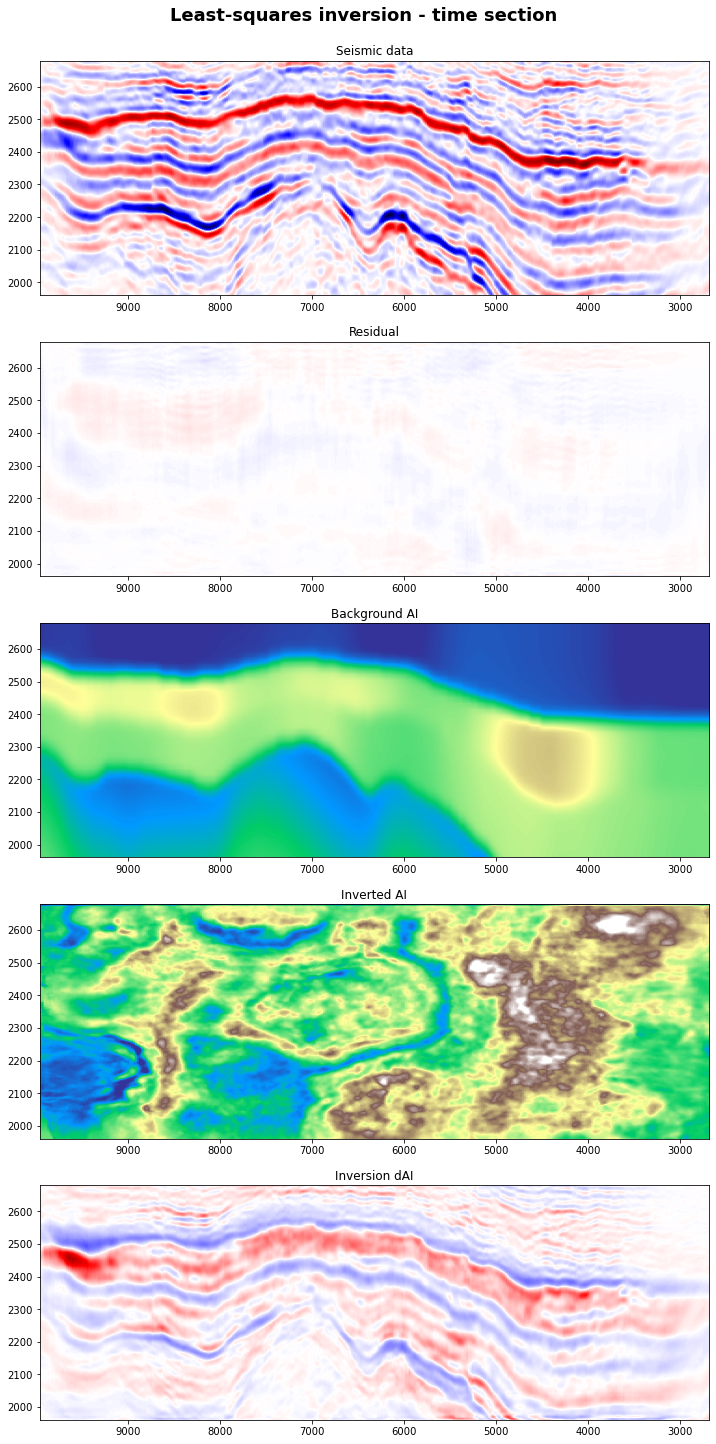

In [22]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Least-squares inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rinv[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp[nil//2].T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(minv[nil//2].T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(minv[nil//2].T -  aiinterp[nil//2].T, cmap='seismic',
              vmin=-0.7*(minv-aiinterp).max(), vmax=0.7*(minv-aiinterp).max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight')

fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Least-squares inversion - time section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rinv[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp[nil//2].T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(minv[..., nt//2], cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(minv[nil//2].T -  aiinterp[nil//2].T, cmap='seismic',
              vmin=-0.7*(minv-aiinterp).max(), vmax=0.7*(minv-aiinterp).max(),
              extent=(ilines[0], xlines[-1], xlines[0], xlines[-1]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');

### Inversion with Primal-Dual

In [23]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0
print(np.max(m0))

# Modeling operator
Lop = PoststackLinearModelling(wav_amp*wav_est, nt0=nt, spatdims=(nxl, nil))
l2 = L2(Op=Lop, b=d.ravel(), niter=70, warm=True)

# Regularization
sigma = 0.2
l1 = L21(ndim=3, sigma=sigma)
Dop = Gradient(dims=(nt, nxl, nil), edge=True, dtype=Lop.dtype, kind='forward')

# Steps
L = 12. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1. / np.sqrt(L)
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, m0.ravel(), tau=tau, mu=mu, theta=1., niter=10, show=True)
rpd = d.ravel() - Lop * mpd

mpd = mpd.reshape(aiinterp.shape)
rpd = rpd.reshape(d.shape)

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
rpd = np.swapaxes(rpd, 0, -1)
mpd = np.swapaxes(np.exp(mpd), 0, -1)

<ipython-input-23-5364b53a5b0a>:5: RuntimeWarning: invalid value encountered in log
  m0 = np.log(aiinterp)


9.55030812870091
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 2.886751e-01	mu = 2.857884e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   5.77063e-02   1.836e+05   3.027e+05   0.000e+00       4.863e+05
     2   8.85981e-02   6.492e+04   3.044e+05   0.000e+00       3.693e+05
     3   1.27763e-01   4.572e+04   3.022e+05   0.000e+00       3.479e+05
     4   1.71610e-01   3.751e+04   2.992e+05   0.000e+00       3.367e+05
     5   2.17243e-01   3.316e+04   2.963e+05   0.000e+00       3.294e+05
     6   2.64567e-01   3.062e+04   2.937e+05   0.000e+00       3.244e+05
     7   3.13475e-01   2.898e+04   2.916e+05   0.000e+00       3.206e+05
     8   3.63843e-01

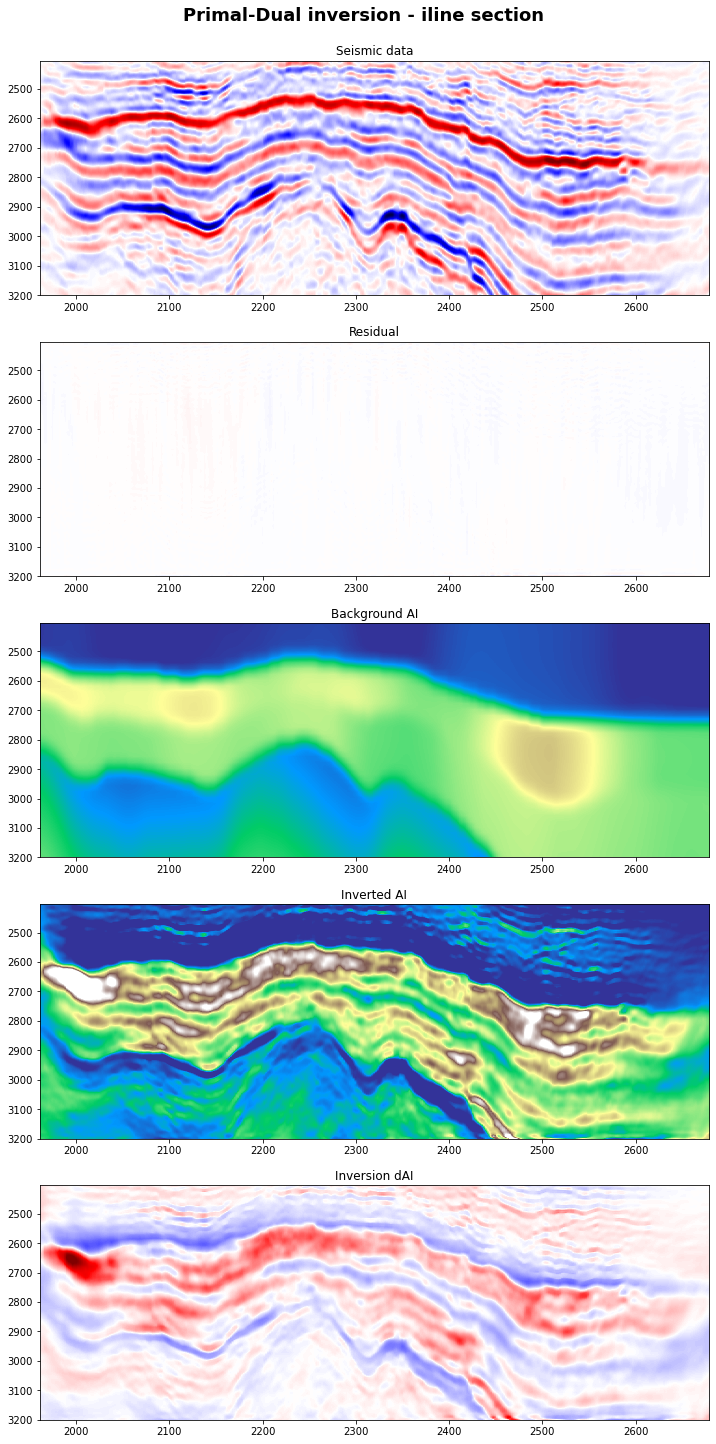

In [24]:
# Visualize
fig, axs = plt.subplots(5, 1, figsize=(12, 25))
fig.suptitle('Primal-Dual inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(rpd[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Residual')
axs[1].axis('tight')
axs[2].imshow(aiinterp[nil//2].T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Background AI')
axs[2].axis('tight')
axs[3].imshow(mpd[nil//2].T, cmap='terrain',
              vmin=6000, vmax=18000,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Inverted AI')
axs[3].axis('tight');
axs[4].imshow(mpd[nil//2].T-aiinterp[nil//2].T, cmap='seismic',
              vmin=-0.7*(minv-aiinterp).max(), vmax=0.7*(minv-aiinterp).max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[4].set_title('Inversion dAI')
axs[4].axis('tight');